# Setting up the environment

In [1]:
from google.colab import drive
import os
from google.colab import userdata

# Step 1: Mount Google Drive
# Mount Google Drive to access your GitHub repository
drive.mount('/content/drive', force_remount=True)

# Step 2: Navigate to Your GitHub Repository
# Change to your repository's location in Google Drive
repo_path = "/content/drive/MyDrive/colab_repos/Wav2Vec2-vs-HUbert"  # Adjust to your repository path
os.chdir(repo_path)

# Step 3: Set Git User Identity
# Configure Git with your username and email for committing
!git config --global user.name "FilipLarsson12"
!git config --global user.email "hockeyfilip12@gmail.com"

# Step 4: Configure Git Remote
# Use the GitHub Personal Access Token from secrets for authentication
github_token = userdata.get("github_access_token")  # Retrieve the secret
repo_url = f"https://{github_token}@github.com/FilipLarsson12/Wav2Vec2-vs-HUbert.git"

# Set or update the Git remote
!git remote set-url origin {repo_url}

# Step 5: Stage, Commit, and Push Changes
# Add the file(s) to the Git staging area
!git add "Wav2Vec2forER KEX.ipynb"  # Adjust to your notebook's name

# Commit with a meaningful message
!git commit -m "Updated Google Colab notebook"

# Push to GitHub
!git push origin main  # Push to 'main'


Mounted at /content/drive
[main b42795d] Updated Google Colab notebook
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite Wav2Vec2forER KEX.ipynb (61%)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 78.66 KiB | 219.00 KiB/s, done.
Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/FilipLarsson12/Wav2Vec2-vs-HUbert.git
   f233ce4..b42795d  main -> main


In [2]:
%%capture

!pip install git+https://github.com/huggingface/datasets.git
!pip install git+https://github.com/huggingface/transformers.git
!pip install jiwer
!pip install torchaudio
!pip install librosa


In [3]:
%env LC_ALL=C.UTF-8
%env LANG=C.UTF-8
%env TRANSFORMERS_CACHE=/content/cache
%env HF_DATASETS_CACHE=/content/cache
%env CUDA_LAUNCH_BLOCKING=1

env: LC_ALL=C.UTF-8
env: LANG=C.UTF-8
env: TRANSFORMERS_CACHE=/content/cache
env: HF_DATASETS_CACHE=/content/cache
env: CUDA_LAUNCH_BLOCKING=1


In [4]:
# Monitor the training process
!pip install wandb

In [5]:
# # Uncomment this part if you want to setup your wandb project
from google.colab import userdata
import os
wandb_token = userdata.get("WANDB_TOKEN")

%env WANDB_WATCH=all
%env WANDB_LOG_MODEL=1
%env WANDB_PROJECT=Wav2Vec2forER
!wandb login {wandb_token} --relogin  # Use the secret for authentication


env: WANDB_WATCH=all
env: WANDB_LOG_MODEL=1
env: WANDB_PROJECT=Wav2Vec2forER
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Loading in and preparing the RAVDESS dataset

In [6]:
from datasets import load_dataset

# Set the custom cache directory to your new destination
import os

# Re-load the dataset with the new cache
dataset = load_dataset("narad/ravdess")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for narad/ravdess contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/narad/ravdess
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.war

In [7]:
import numpy as np
import pandas as pd

from pathlib import Path
from tqdm import tqdm

import torchaudio
from sklearn.model_selection import train_test_split

import os
import sys

In [8]:
import torchaudio
import librosa
import IPython.display as ipd
import numpy as np

In [9]:
print(dataset['train'])

Dataset({
    features: ['audio', 'text', 'labels', 'speaker_id', 'speaker_gender'],
    num_rows: 1440
})


Creating label2id and id2label dictionaries to get easier overview of classes and labels.

In [10]:
# Get information about the dataset
print(dataset['train'].features)
label_names = dataset['train'].features['labels'].names
print(label_names)

# Create a dictionary mapping label names to their corresponding IDs
label2id = {name: idx for idx, name in enumerate(label_names)}

# Create a dictionary mapping label IDs to their corresponding label names
id2label = {idx: name for idx, name in enumerate(label_names)}

# Print the dictionaries
print("Label to ID:", label2id)
print("ID to Label:", id2label)

{'audio': Audio(sampling_rate=48000, mono=True, decode=True, id=None), 'text': Value(dtype='string', id=None), 'labels': ClassLabel(names=['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised'], id=None), 'speaker_id': Value(dtype='string', id=None), 'speaker_gender': Value(dtype='string', id=None)}
['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
Label to ID: {'neutral': 0, 'calm': 1, 'happy': 2, 'sad': 3, 'angry': 4, 'fearful': 5, 'disgust': 6, 'surprised': 7}
ID to Label: {0: 'neutral', 1: 'calm', 2: 'happy', 3: 'sad', 4: 'angry', 5: 'fearful', 6: 'disgust', 7: 'surprised'}


In [11]:
df = dataset['train'].to_pandas()

Adding an emotion column to the Dataframe to make things more clear.

In [12]:
df["emotion"] = df["labels"].map(id2label)

In [13]:
df.head()

,audio,text,labels,speaker_id,speaker_gender,emotion
0,"{'bytes': None, 'path': '/content/cache/downlo...",Kids are talking by the door,0,11,male,neutral
1,"{'bytes': None, 'path': '/content/cache/downlo...",Dogs are sitting by the door,7,11,male,surprised
2,"{'bytes': None, 'path': '/content/cache/downlo...",Dogs are sitting by the door,4,11,male,angry
3,"{'bytes': None, 'path': '/content/cache/downlo...",Kids are talking by the door,1,11,male,calm
4,"{'bytes': None, 'path': '/content/cache/downlo...",Kids are talking by the door,2,11,male,happy


Listening to a random sample:

In [14]:
idx = np.random.randint(0, len(df))
sample = df.iloc[idx]

path = sample['audio']["path"]
label = sample["emotion"]
labelid = sample['labels']


print(f"ID Location: {idx}")
print(f"      Label: {label}")
print(f"      Label: {labelid}")

print()

speech, sr = torchaudio.load(path)
print(path)
print(speech[0])
speech = speech[0].numpy().squeeze()
print(speech)
speech = librosa.resample(y=speech, orig_sr=sr, target_sr=16000)  # Corrected usage
ipd.Audio(data=np.asarray(speech), autoplay=False, rate=16000)

ID Location: 473
      Label: calm
      Label: 1

/content/cache/downloads/extracted/90a2946071fd672392e66dcb12cae53c7db0f9869229dc41def316e96a8dc54b/Actor_03/03-01-02-02-01-01-03.wav
tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
         0.0000e+00, -6.1035e-05])
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  0.0000000e+00 -6.1035156e-05]


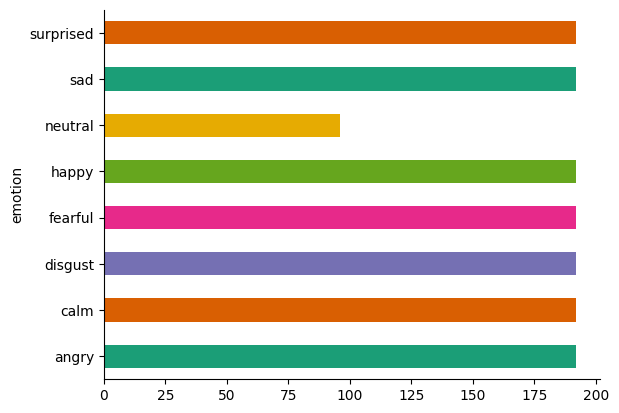

In [15]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('emotion').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [16]:
print("Labels: ", df["emotion"].unique())
print()
df.groupby("emotion").count()['audio']

Labels:  ['neutral' 'surprised' 'angry' 'calm' 'happy' 'sad' 'disgust' 'fearful']



emotion
angry        192
calm         192
disgust      192
fearful      192
happy        192
neutral       96
sad          192
surprised    192
Name: audio, dtype: int64

Restructuring the dataframe a bit for clarity:

In [17]:
df["path"] = df["audio"].apply(lambda audio: audio.get("path", None))



In [18]:
df.head()

,audio,text,labels,speaker_id,speaker_gender,emotion,path
0,"{'bytes': None, 'path': '/content/cache/downlo...",Kids are talking by the door,0,11,male,neutral,/content/cache/downloads/extracted/90a2946071f...
1,"{'bytes': None, 'path': '/content/cache/downlo...",Dogs are sitting by the door,7,11,male,surprised,/content/cache/downloads/extracted/90a2946071f...
2,"{'bytes': None, 'path': '/content/cache/downlo...",Dogs are sitting by the door,4,11,male,angry,/content/cache/downloads/extracted/90a2946071f...
3,"{'bytes': None, 'path': '/content/cache/downlo...",Kids are talking by the door,1,11,male,calm,/content/cache/downloads/extracted/90a2946071f...
4,"{'bytes': None, 'path': '/content/cache/downlo...",Kids are talking by the door,2,11,male,happy,/content/cache/downloads/extracted/90a2946071f...


Now we are gonna split the dataset into a train and test split and also save them into content/data as csv files:

In [19]:
import os

save_path = "/content/data"

os.makedirs(save_path, exist_ok=True)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=101, stratify=df["labels"])

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_df.to_csv(f"{save_path}/train.csv", sep="\t", encoding="utf-8", index=False)
test_df.to_csv(f"{save_path}/test.csv", sep="\t", encoding="utf-8", index=False)


print(train_df.shape)
print(test_df.shape)

(1152, 7)
(288, 7)


In [20]:
# Loading the created dataset using datasets
from datasets import load_dataset, load_metric


data_files = {
    "train": "/content/data/train.csv",
    "validation": "/content/data/test.csv",
}

dataset = load_dataset("csv", data_files=data_files, delimiter="\t", )
print(dataset['train'][0])
train_dataset = dataset["train"]
eval_dataset = dataset["validation"]

print(train_dataset)
print(eval_dataset)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

{'audio': "{'bytes': None, 'path': '/content/cache/downloads/extracted/90a2946071fd672392e66dcb12cae53c7db0f9869229dc41def316e96a8dc54b/Actor_13/03-01-03-02-01-02-13.wav'}", 'text': 'Kids are talking by the door', 'labels': 2, 'speaker_id': 13, 'speaker_gender': 'male', 'emotion': 'happy', 'path': '/content/cache/downloads/extracted/90a2946071fd672392e66dcb12cae53c7db0f9869229dc41def316e96a8dc54b/Actor_13/03-01-03-02-01-02-13.wav'}
Dataset({
    features: ['audio', 'text', 'labels', 'speaker_id', 'speaker_gender', 'emotion', 'path'],
    num_rows: 1152
})
Dataset({
    features: ['audio', 'text', 'labels', 'speaker_id', 'speaker_gender', 'emotion', 'path'],
    num_rows: 288
})


In [21]:
input_column = "path"
output_column = "emotion"

In [22]:
# we need to distinguish the unique labels in our SER dataset
label_list = train_dataset.unique(output_column)
label_list.sort()  # Let's sort it for determinism
num_labels = len(label_list)
print(f"A classification problem with {num_labels} classes: {label_list}")

A classification problem with 8 classes: ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


# Loading in the Wav2Vec2 model

In [23]:
from transformers import AutoConfig, Wav2Vec2Processor

/usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [24]:
model_name_or_path = "facebook/wav2vec2-large-960h"
pooling_mode = "mean"

In [25]:
print(label2id)
print(id2label)

# config
config = AutoConfig.from_pretrained(
    model_name_or_path,
    num_labels=len(label_list),
    label2id=label2id,
    id2label=id2label,
    finetuning_task="wav2vec2_clf",
)
setattr(config, 'pooling_mode', pooling_mode)
print(config)

{'neutral': 0, 'calm': 1, 'happy': 2, 'sad': 3, 'angry': 4, 'fearful': 5, 'disgust': 6, 'surprised': 7}
{0: 'neutral', 1: 'calm', 2: 'happy', 3: 'sad', 4: 'angry', 5: 'fearful', 6: 'disgust', 7: 'surprised'}
Wav2Vec2Config {
  "_name_or_path": "facebook/wav2vec2-base-960h",
  "activation_dropout": 0.1,
  "adapter_attn_dim": null,
  "adapter_kernel_size": 3,
  "adapter_stride": 2,
  "add_adapter": false,
  "apply_spec_augment": true,
  "architectures": [
    "Wav2Vec2ForCTC"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 1,
  "classifier_proj_size": 256,
  "codevector_dim": 256,
  "contrastive_logits_temperature": 0.1,
  "conv_bias": false,
  "conv_dim": [
    512,
    512,
    512,
    512,
    512,
    512,
    512
  ],
  "conv_kernel": [
    10,
    3,
    3,
    3,
    3,
    2,
    2
  ],
  "conv_stride": [
    5,
    2,
    2,
    2,
    2,
    2,
    2
  ],
  "ctc_loss_reduction": "sum",
  "ctc_zero_infinity": false,
  "diversity_loss_weight": 0.1,
  "do_stable_layer_norm": f

In [26]:
processor = Wav2Vec2Processor.from_pretrained(model_name_or_path)
print(processor)
target_sampling_rate = processor.feature_extractor.sampling_rate
print(f"The target sampling rate: {target_sampling_rate}")

Wav2Vec2Processor:
- feature_extractor: Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0.0,
  "return_attention_mask": false,
  "sampling_rate": 16000
}

- tokenizer: Wav2Vec2CTCTokenizer(name_or_path='facebook/wav2vec2-base-960h', vocab_size=32, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<pad>", rstrip=True, lstrip=True, single_word=False, normalized=False, special=False),
	1: AddedToken("<s>", rstrip=True, lstrip=True, single_word=False, normalized=False, special=False),
	2: AddedToken("</s>", rstrip=True, lstrip=True, single_word=False, normalized=False, special=False),
	3: AddedToken("<unk>", rstrip=True, lstrip=Tr

In [27]:
def speech_file_to_array_fn(path):
    try:
        # Load and resample the audio
        speech_array, sampling_rate = torchaudio.load(path)
        resampler = torchaudio.transforms.Resample(sampling_rate, target_sampling_rate)
        speech = resampler(speech_array)
        speech = speech.flatten()

        # Convert to numpy array
        speech = speech.numpy()

        if len(speech.shape) != 1:
            print("Hej")
            raise ValueError("Expected a 1D numpy array of float values.")

    except Exception as e:
        print(f"Error processing file {path}: {e}")
        # Return a consistent placeholder (empty array)
        speech = np.array([])

    return speech



def label_to_id(label, label_list):

    if len(label_list) > 0:
        return label_list.index(label) if label in label_list else -1

    return label

def preprocess_function(examples):
    speech_list = [speech_file_to_array_fn(path) for path in examples[input_column]]
    target_list = [label2id[label] for label in examples[output_column]]

    result = processor(speech_list, sampling_rate=target_sampling_rate)
    result["labels"] = list(target_list)

    return result

In [28]:
train_dataset_copy = train_dataset
sample1 = speech_file_to_array_fn(train_dataset_copy[0]['path'])
print(sample1)
print(processor.feature_extractor)

[ 4.1950916e-05  4.8059053e-05  3.8841576e-05 ... -6.1489787e-05
 -8.0408980e-05 -6.3026317e-05]
Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0.0,
  "return_attention_mask": false,
  "sampling_rate": 16000
}



In [29]:
processed_sample_1 = processor(sample1, sampling_rate=target_sampling_rate)
print(processed_sample_1)

{'input_values': [array([ 0.00254684,  0.00286601,  0.00238437, ..., -0.0028583 ,
       -0.00384689, -0.00293859], dtype=float32)]}


In [30]:
print(len(train_dataset))
print(len(eval_dataset))


train_dataset = train_dataset.map(
    preprocess_function,
    batch_size=100,
    batched=True,
    num_proc=4
)

eval_dataset = eval_dataset.map(
    preprocess_function,
    batch_size=100,
    batched=True,
    num_proc=4
)

print(len(train_dataset))
print(len(eval_dataset))
print(train_dataset)

1152
288


/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=4):   0%|          | 0/1152 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/288 [00:00<?, ? examples/s]

1152
288
Dataset({
    features: ['audio', 'text', 'labels', 'speaker_id', 'speaker_gender', 'emotion', 'path', 'input_values'],
    num_rows: 1152
})


In [31]:
idx = 0
print(f"Training input_values: {train_dataset[idx]['input_values']}")
print(f"Training labels: {train_dataset[idx]['labels']} - {train_dataset[idx]['emotion']}")

Training input_values: [0.0025468417443335056, 0.002866013441234827, 0.0023843678645789623, 0.002401866251602769, 0.003018558956682682, 0.00289173168130219, 0.003001077799126506, 0.003183632856234908, 0.0018110456876456738, 0.0036305522080510855, 0.0030933686066418886, 0.0028225225396454334, 0.003344681579619646, 0.003212451469153166, 0.0028987927362322807, 0.0035514633636921644, 0.00382607732899487, 0.004386747255921364, 0.005377710796892643, 0.003878667252138257, 0.004104116000235081, 0.004737736191600561, 0.004006955306977034, 0.0050363969057798386, 0.0036120200529694557, 0.0039426470175385475, 0.0038329288363456726, 0.0030447563622146845, 0.003285320708528161, 0.003861743723973632, 0.0035106621216982603, 0.003329704748466611, 0.003225701628252864, 0.0032746675424277782, 0.003654557978734374, 0.003472308861091733, 0.003635220229625702, 0.0033214865252375603, 0.003125435207039118, 0.0036065117456018925, 0.003590835491195321, 0.002607084112241864, 0.0038513755425810814, 0.003611574415

# Defining the model

Now we're going to create custom classes that define our model which will consist of the base wav2vec2 model + a classification head that succeeds the wav2vec2 model.

In [32]:
from dataclasses import dataclass
from typing import Optional, Tuple
import torch
from transformers.file_utils import ModelOutput


@dataclass
class SpeechClassifierOutput(ModelOutput):
    loss: Optional[torch.FloatTensor] = None
    logits: torch.FloatTensor = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None

In [33]:
import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

from transformers.models.wav2vec2.modeling_wav2vec2 import (
    Wav2Vec2PreTrainedModel,
    Wav2Vec2Model,
    Wav2Vec2ForCTC
)


class Wav2Vec2ClassificationHead(nn.Module):
    """Head for wav2vec classification task."""

    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(config.final_dropout)
        self.out_proj = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, features, **kwargs):
        x = features
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x


class Wav2Vec2ForSpeechClassification(Wav2Vec2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.pooling_mode = config.pooling_mode
        self.config = config

        self.wav2vec2 = Wav2Vec2Model(config)
        self.classifier = Wav2Vec2ClassificationHead(config)

        self.init_weights()

    def freeze_feature_extractor(self):
        self.wav2vec2.feature_extractor._freeze_parameters()

    def merged_strategy(
            self,
            hidden_states,
            mode="mean"
    ):
        if mode == "mean":
            outputs = torch.mean(hidden_states, dim=1)
        elif mode == "sum":
            outputs = torch.sum(hidden_states, dim=1)
        elif mode == "max":
            outputs = torch.max(hidden_states, dim=1)[0]
        else:
            raise Exception(
                "The pooling method hasn't been defined! Your pooling mode must be one of these ['mean', 'sum', 'max']")

        return outputs

    def forward(
            self,
            input_values,
            attention_mask=None,
            output_attentions=None,
            output_hidden_states=None,
            return_dict=None,
            labels=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        outputs = self.wav2vec2(
            input_values,
            attention_mask=attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        hidden_states = outputs[0]
        hidden_states = self.merged_strategy(hidden_states, mode=self.pooling_mode)
        logits = self.classifier(hidden_states)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SpeechClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


In [34]:
print("Columns in train_dataset:", train_dataset.column_names)
# Display the first few examples
print("Sample data from train_dataset:")
print(train_dataset[0:1])  # Adjust the slice to see more or fewer examples


Columns in train_dataset: ['audio', 'text', 'labels', 'speaker_id', 'speaker_gender', 'emotion', 'path', 'input_values']
Sample data from train_dataset:
{'audio': ["{'bytes': None, 'path': '/content/cache/downloads/extracted/90a2946071fd672392e66dcb12cae53c7db0f9869229dc41def316e96a8dc54b/Actor_13/03-01-03-02-01-02-13.wav'}"], 'text': ['Kids are talking by the door'], 'labels': [2], 'speaker_id': [13], 'speaker_gender': ['male'], 'emotion': ['happy'], 'path': ['/content/cache/downloads/extracted/90a2946071fd672392e66dcb12cae53c7db0f9869229dc41def316e96a8dc54b/Actor_13/03-01-03-02-01-02-13.wav'], 'input_values': [[0.0025468417443335056, 0.002866013441234827, 0.0023843678645789623, 0.002401866251602769, 0.003018558956682682, 0.00289173168130219, 0.003001077799126506, 0.003183632856234908, 0.0018110456876456738, 0.0036305522080510855, 0.0030933686066418886, 0.0028225225396454334, 0.003344681579619646, 0.003212451469153166, 0.0028987927362322807, 0.0035514633636921644, 0.00382607732899487,

Cleaning up the datasets:

In [35]:
train_dataset = train_dataset.remove_columns("audio")
eval_dataset = eval_dataset.remove_columns("audio")
train_dataset = train_dataset.remove_columns("text")
eval_dataset = eval_dataset.remove_columns("text")
train_dataset = train_dataset.remove_columns("speaker_id")
eval_dataset = eval_dataset.remove_columns("speaker_id")
train_dataset = train_dataset.remove_columns("speaker_gender")
eval_dataset = eval_dataset.remove_columns("speaker_gender")

In [36]:
print("Columns in train_dataset:", train_dataset.column_names)
# Display the first few examples
print("Sample data from train_dataset:")
print(train_dataset[0])  # Adjust the slice to see more or fewer examples


Columns in train_dataset: ['labels', 'emotion', 'path', 'input_values']
Sample data from train_dataset:
{'labels': 2, 'emotion': 'happy', 'path': '/content/cache/downloads/extracted/90a2946071fd672392e66dcb12cae53c7db0f9869229dc41def316e96a8dc54b/Actor_13/03-01-03-02-01-02-13.wav', 'input_values': [0.0025468417443335056, 0.002866013441234827, 0.0023843678645789623, 0.002401866251602769, 0.003018558956682682, 0.00289173168130219, 0.003001077799126506, 0.003183632856234908, 0.0018110456876456738, 0.0036305522080510855, 0.0030933686066418886, 0.0028225225396454334, 0.003344681579619646, 0.003212451469153166, 0.0028987927362322807, 0.0035514633636921644, 0.00382607732899487, 0.004386747255921364, 0.005377710796892643, 0.003878667252138257, 0.004104116000235081, 0.004737736191600561, 0.004006955306977034, 0.0050363969057798386, 0.0036120200529694557, 0.0039426470175385475, 0.0038329288363456726, 0.0030447563622146845, 0.003285320708528161, 0.003861743723973632, 0.0035106621216982603, 0.0033

# Training!!

Now we will perform the final steps necessary and then start the training process.

In [37]:
test_data = [
    {"input_values": list(range(10)), "labels": 0},
    {"input_values": list(range(20)), "labels": 1},
    {"input_values": list(range(15)), "labels": 2},
]

In [38]:
from dataclasses import dataclass
from typing import Dict, List, Optional, Union
import torch
from transformers import Wav2Vec2Processor


@dataclass
class DataCollatorWithPadding:
    """
    Data collator that pads only the input sequences, leaving the output labels unchanged.
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # Extract and pad only the input values
        input_features = [{"input_values": feature["input_values"]} for feature in features]

        # Pad the input values with the given strategy and other specified options
        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",  # Return padded input as PyTorch tensors
        )

        # Add labels to the batch without padding or modifications
        # Ensure the correct data type for labels
        label_features = [feature["labels"] for feature in features]
        d_type = torch.long if isinstance(label_features[0], int) else torch.float

        batch["labels"] = torch.tensor(label_features, dtype=d_type)


        return batch


In [39]:
data_collator = DataCollatorWithPadding(processor=processor, padding=True)

In [40]:
batch = data_collator(test_data)

In [41]:
is_regression = False

In [42]:
import numpy as np
from transformers import EvalPrediction


def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.squeeze(preds) if is_regression else np.argmax(preds, axis=1)

    if is_regression:
        return {"mse": ((preds - p.label_ids) ** 2).mean().item()}
    else:
        return {"accuracy": (preds == p.label_ids).astype(np.float32).mean().item()}

Instantiating the model:

In [43]:
model = Wav2Vec2ForSpeechClassification.from_pretrained(
    model_name_or_path,
    config=config,
)
print(config)

Some weights of Wav2Vec2ForSpeechClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2Config {
  "_name_or_path": "facebook/wav2vec2-base-960h",
  "activation_dropout": 0.1,
  "adapter_attn_dim": null,
  "adapter_kernel_size": 3,
  "adapter_stride": 2,
  "add_adapter": false,
  "apply_spec_augment": true,
  "architectures": [
    "Wav2Vec2ForCTC"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 1,
  "classifier_proj_size": 256,
  "codevector_dim": 256,
  "contrastive_logits_temperature": 0.1,
  "conv_bias": false,
  "conv_dim": [
    512,
    512,
    512,
    512,
    512,
    512,
    512
  ],
  "conv_kernel": [
    10,
    3,
    3,
    3,
    3,
    2,
    2
  ],
  "conv_stride": [
    5,
    2,
    2,
    2,
    2,
    2,
    2
  ],
  "ctc_loss_reduction": "sum",
  "ctc_zero_infinity": false,
  "diversity_loss_weight": 0.1,
  "do_stable_layer_norm": false,
  "eos_token_id": 2,
  "feat_extract_activation": "gelu",
  "feat_extract_dropout": 0.0,
  "feat_extract_norm": "group",
  "feat_proj_dropout": 0.1,
  "feat_quantizer_dropout": 0.0,
  "final_dropout": 0

In [44]:
import numpy as np

def generate_sine_wave(freq, sample_rate, duration):
    t = np.linspace(0, duration, int(sample_rate * duration), False)  # Time axis
    waveform = np.sin(2 * np.pi * freq * t)  # Sine wave
    return waveform

# Parameters
sample_rate = 16000  # 16 kHz sample rate, typical for audio processing
durations = [1.0, 0.5, 2.0]  # Durations in seconds
frequencies = [440, 1000, 250]  # Frequencies in Hz

# Generate synthetic audio data
audio_samples = [generate_sine_wave(freq, sample_rate, duration)
                 for freq, duration in zip(frequencies, durations)]
print(audio_samples[0])


[ 0.          0.1719291   0.33873792 ... -0.49545867 -0.33873792
 -0.1719291 ]


In [45]:
model.freeze_feature_extractor()

In [46]:
%%capture

!pip install accelerate -U
!pip install transformers[torch]

In [47]:
!pip show accelerate

Name: accelerate
Version: 0.29.3
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: zach.mueller@huggingface.co
License: Apache
Location: /usr/local/lib/python3.10/dist-packages
Requires: huggingface-hub, numpy, packaging, psutil, pyyaml, safetensors, torch
Required-by: 


In [48]:
from transformers import TrainingArguments

"""
training_args = TrainingArguments(
    output_dir="/content/wav2vec2-base-960h-RAVDESS",
    per_device_train_batch_size=16,  # Increased from 4
    per_device_eval_batch_size=16,  # Increased from 4
    gradient_accumulation_steps=3,  # Adjusted to accumulate gradients more frequently
    evaluation_strategy="steps",
    num_train_epochs=10.0,  # Increased to explore longer training
    fp16=True,
    save_steps=50,  # Increased to reduce I/O overhead
    eval_steps=50,  # Increased for consistent evaluation
    logging_steps=50,  # Adjusted for consistent logging
    learning_rate=3.5e-05,  # Intermediate learning rate
    save_total_limit=3,  # Increased limit for saved checkpoints
)
"""

training_args = TrainingArguments(
    output_dir="/content/wav2vec2-xlsr-greek-speech-emotion-recognition",
    # output_dir="/content/MyDrive/wav2vec2-xlsr-greek-speech-emotion-recognition"
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    evaluation_strategy="steps",
    num_train_epochs=5.0,
    fp16=True,
    save_steps=10,
    eval_steps=10,
    logging_steps=10,
    learning_rate=5e-6,
    save_total_limit=2,
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1463: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Osäker om denna ska vara kvar eller inte

In [49]:
from typing import Any, Dict, Union
import torch
from torch import nn
from transformers import Trainer

class EmotionRecognitionTrainer(Trainer):
    def training_step(self, model: nn.Module, inputs: Dict[str, Union[torch.Tensor, Any]]) -> torch.Tensor:
        """
        Perform a training step on a batch of inputs.

        Subclass and override to inject custom behavior.

        Args:
            model (:obj:`nn.Module`):
                The model to train.
            inputs (:obj:`Dict[str, Union[torch.Tensor, Any]]`):
                The inputs and targets of the model.

        Return:
            :obj:`torch.Tensor`: The tensor with training loss on this batch.
        """

        model.train()
        inputs = self._prepare_inputs(inputs)

        loss = self.compute_loss(model, inputs)  # Compute loss using the standard method

        if self.args.gradient_accumulation_steps > 1:
            loss = loss / self.args.gradient_accumulation_steps

        loss.backward()  # Perform backpropagation

        return loss.detach()  # Return the loss for tracking

In [50]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor.feature_extractor,
)

In [51]:
trainer.train()

wandb: Currently logged in as: filiplarsson. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy
10,2.094500,2.078495,0.135417
20,2.088300,2.072584,0.170139
30,2.067500,2.068698,0.163194
40,2.068700,2.066311,0.135417
50,2.075700,2.064551,0.135417
60,2.080900,2.062737,0.152778
70,2.055700,2.060784,0.145833
80,2.089000,2.058336,0.152778
90,2.054500,2.056051,0.163194


KeyboardInterrupt: 